In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd

import utils.luigi_wrapper as luigi
from utils.utils import *

# from preprocess.questions_label_extraction import QuestionsLabelExtractionTask
# from questions_model.create_predictions import QuestionsMakePredictionsTask
# from preprocess.train_test_split import TrainTestSplitTask
# from preprocess.data_tokenization import DataTokenizationTask
# from preprocess.feature_selection import FeatureSelectionTask
from preprocess.create_dataset import CreateDataSetTask
from preprocess.dataset import DataSet


from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, f1_score

from IPython.display import display

In [2]:
from scipy.sparse.csgraph import minimum_spanning_tree
import networkx as nx

In [3]:
pd.set_option('max_rows', 70)

In [4]:
def get_prior(y):
    num_of_pages = y.shape[0]
    num_of_classes = y.shape[1]

    p_ij = np.zeros((num_of_classes, num_of_classes))
    for lst in y:
        for i in range(num_of_classes):
            for j in range(num_of_classes):
                p_ij[i, j] += (lst[i] * lst[j]) / num_of_pages
    return p_ij

def get_mutual_information(p_ij, nan=0, neginf=-5):
    E = np.zeros(p_ij.shape)
    for i in range(p_ij.shape[0]):
        for j in range(p_ij.shape[0]):
            i1_j1 = p_ij[i,j] * np.log(p_ij[i,j] / (p_ij[i, i] * p_ij[j, j]))
            i1_j0 = (p_ij[i,i] - p_ij[i,j]) * np.log((p_ij[i,i] - p_ij[i,j]) / (p_ij[i,i] * (1 - p_ij[j,j])))
            i0_j1 = (p_ij[j,j] - p_ij[i,j]) * np.log((p_ij[j,j] - p_ij[i,j]) / (p_ij[j,j] * (1 - p_ij[i,i])))
            i0_j0 = (1 - p_ij[j,j] - p_ij[i,i] + p_ij[i,j]) * np.log((1 - p_ij[j,j] - p_ij[i,i] + p_ij[i,j]) / (1 - p_ij[j,j]) * (1 - p_ij[i,i]))
            E[i, j] = i1_j1 + i1_j0 + i0_j1 + i0_j0
    E_filled = - np.nan_to_num(E, nan=nan, neginf=neginf)
    return E_filled

def theta(p_ij, i, j, i_val, j_val):
    if i_val == 1 and j_val == 1:
        return p_ij[i,j] / (p_ij[i,i] * p_ij[j,j])
    elif i_val == 1 and j_val == 0:
        return (p_ij[i,i] - p_ij[i,j]) / (p_ij[i,i] * (1 - p_ij[j,j]))
    elif i_val == 0 and j_val == 1:
        return (p_ij[j,j] - p_ij[i,j]) / (p_ij[j,j] * (1 - p_ij[i,i]))
    elif i_val == 0 and j_val == 0:
        return (1 - p_ij[j,j] - p_ij[i,i] + p_ij[i,j]) / ((1 - p_ij[j,j]) * (1 - p_ij[i,i]))
    
def get_neg_conn_strength(p_ij):
    conn_strength = np.zeros(p_ij.shape)
    for i in range(p_ij.shape[0]):
        for j in range(p_ij.shape[0]):
            conn_strength[i, j] = (theta(p_ij, i, j, 1, 0) + theta(p_ij, i, j, 0, 1)) / 2
    return conn_strength

In [5]:
def get_neg_mutual_information(p_ij, nan=0, neginf=-5):
    E = np.zeros(p_ij.shape)
    for i in range(p_ij.shape[0]):
        for j in range(p_ij.shape[0]):
            i1_j0 = (p_ij[i,i] - p_ij[i,j]) * np.log((p_ij[i,i] - p_ij[i,j]) / (p_ij[i,i] * (1 - p_ij[j,j])))
            i0_j1 = (p_ij[j,j] - p_ij[i,j]) * np.log((p_ij[j,j] - p_ij[i,j]) / (p_ij[j,j] * (1 - p_ij[i,i])))
            E[i, j] = i1_j0 + i0_j1
    E_filled = - np.nan_to_num(E, nan=nan, neginf=neginf)
    return E_filled

In [6]:
def get_y_by_thresh(y_proba, th= 0.5):
    return (y_proba > th).astype(int)

def get_thresh(y_true, y_pred, n_thers = 500, plot=False):
    thresholds = [n / n_thers for n in list(range(1, n_thers, 1))]
    f1_scores = [f1_score(y_true, get_y_by_thresh(y_pred, thresh), average = 'macro') for thresh in thresholds]
    
    if plot:
        plt.plot(thresholds, f1_scores)
        plt.show()
    
    return thresholds[np.argmax(f1_scores)]

def normalize(y_proba, th= 0.5):
    y_proba_fixed = np.zeros(y_proba.shape)
    y_proba_fixed[y_proba<th] = (y_proba[y_proba<th] / th) * 0.5
    y_proba_fixed[y_proba>=th] = ((y_proba[y_proba>=th] - th) / (1-th)) * 0.5 + 0.5
    return y_proba_fixed

# def sigmoid_normalize(y_proba, th= 0.5):
#     y_proba_fixed = np.zeros(y_proba.shape)
#     y_proba_fixed = 1 / (1 + np.exp())
#     return y_proba_fixed

def get_y(y_test, y_proba, do_normalize=False):
    y = []
    y_proba_fixed = []
    for c in range(y_proba.shape[1]):
        y_proba_c = y_proba[:, c]
        y_test_c = y_test[:, c]
        th = get_thresh(y_test_c, y_proba_c)
        y.append(get_y_by_thresh(y_proba_c, th))
        y_proba_fixed.append(normalize(y_proba_c, th))
    
    if do_normalize:
        return np.array(y).T, np.array(y_proba_fixed).T
    else:
        return np.array(y).T, y_proba    

## Read Data

In [7]:
data: DataSet = read_data(get_file_path('dataset.pickle', 'data'))
X = data.X
y = data.y
X_train, X_test = data.X_train, data.X_test
y_train, y_test = data.y_train, data.y_test

## Get Prior

In [8]:
p_ij = get_prior(y_train)

## Train Model

In [9]:
from lightgbm import LGBMClassifier
from sklearn.multiclass import OneVsRestClassifier
model = OneVsRestClassifier(LGBMClassifier(class_weight = 'balanced'), n_jobs=-2)
#model.fit(X_train, y_train)

In [10]:
#pickle.dump(model, open('temp_model.pickle', 'wb'))

In [11]:
model = pickle.load(open('temp_model.pickle', 'rb'))

In [12]:
y_pred_proba = model.predict_proba(X_test)

In [13]:
#print(classification_report(y_test, np.round(y_pred_proba)))

## Priored Predictions

In [14]:
global messages_dict
messages_dict = {}

In [15]:
def message(p_ij, T, prediction, i, parent, parent_val):
    N = []
    #print(f'child: {i}, parent: {parent}')
    for j in range(len(prediction)):
        if (T[i,j] != 0 or T[j,i] != 0) and j != parent and j != i:
            N.append(j)
    if f'{i}_{parent}_{parent_val}' in messages_dict.keys():
        m1 = messages_dict[f'{i}_{parent}_{parent_val}'][1]
        m0 = messages_dict[f'{i}_{parent}_{parent_val}'][0]
    else:
        #print('calculate')
        if len(N) > 0 :  
            m1 = theta(p_ij, i, parent, 1, parent_val) * prediction[i] * np.prod([message(p_ij, T, prediction, n, i, 1) for n in N])
            #print('theta1: ' + str(theta(p_ij, i, parent, 1, parent_val)))
            m0 = theta(p_ij, i, parent, 0, parent_val) * (1 - prediction[i]) * np.prod([message(p_ij, T, prediction, n, i, 0) for n in N])
            #print('theta0: ' + str(theta(p_ij, i, parent, 0, parent_val)))

        else:
            m1 = theta(p_ij, i, parent, 1, parent_val) * prediction[i]
            m0 = theta(p_ij, i, parent, 0, parent_val) * (1 - prediction[i])
        
        messages_dict[f'{i}_{parent}_{parent_val}'] = (m0, m1)
    #  m1 + m0 - ?
    return m1 + m0     

In [16]:
def run_prior_on_prediction(p_ij, T, prediction):
    
    priored_prediction = []
    global messages_dict
    messages_dict = {}
    
    for i in range(len(prediction)):
        p_i_new = 0
        N = []
        for j in range(len(prediction)):
            if T[i,j] != 0 or T[j,i] != 0:
                N.append(j)
        
        messages1 = [message(p_ij, T, prediction, n, i, 1) for n in N]
        messages0 = [message(p_ij, T, prediction, n, i, 0) for n in N]
            
        p_i1 = prediction[i] * np.prod(messages1) #* p_ij[i,i]
        p_i0 = (1 - prediction[i]) * np.prod(messages0) * (1- p_ij[i,i])
            
        p_i_new += p_i1 / (p_i1 + p_i0)
            

        priored_prediction.append(p_i_new)
    return priored_prediction

### y_pred w/o prior

In [17]:
y_pred, y_pred_proba = get_y(y_test, y_pred_proba)

### y_pred with pos prior

In [18]:
E = get_mutual_information(p_ij)
T = minimum_spanning_tree(E)

C:\Users\Aviv\Anaconda3\envs\research_env\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
C:\Users\Aviv\Anaconda3\envs\research_env\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Aviv\Anaconda3\envs\research_env\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log
C:\Users\Aviv\Anaconda3\envs\research_env\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Aviv\Anaconda3\envs\research_env\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
C:\Users\Aviv\Anaconda3\envs\research_env\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


In [19]:
#y_pred_after_prior_proba_pos = np.array([run_prior_on_prediction(p_ij, T, p) for p in y_pred_proba])

In [20]:
#pickle.dump(y_pred_after_prior_proba_pos, open('y_pred_after_prior_proba_pos.pickle', 'wb'))

In [21]:
y_pred_after_prior_proba_pos = pickle.load(open('y_pred_after_prior_proba_pos.pickle', 'rb'))

In [22]:
y_pred_after_prior, y_pred_after_prior_proba_pos = get_y(y_test, y_pred_after_prior_proba_pos)

### y_pred with  neg prior

In [23]:
E_neg = get_neg_mutual_information(p_ij)
T_neg = minimum_spanning_tree(E_neg)

C:\Users\Aviv\Anaconda3\envs\research_env\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
C:\Users\Aviv\Anaconda3\envs\research_env\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """
C:\Users\Aviv\Anaconda3\envs\research_env\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
C:\Users\Aviv\Anaconda3\envs\research_env\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


In [24]:
y_pred_after_prior_proba_neg = np.array([run_prior_on_prediction(p_ij, T_neg, p) for p in y_pred_proba])

In [25]:
#pickle.dump(y_pred_after_prior_proba_neg, open('y_pred_after_prior_proba_neg.pickle', 'wb'))

In [26]:
#y_pred_after_prior_proba_neg = pickle.load(open('y_pred_after_prior_proba_neg.pickle', 'rb'))

In [27]:
y_pred_after_prior_neg, y_pred_after_prior_neg_proba = get_y(y_test, y_pred_after_prior_proba_neg)

## Neg After Pos

In [28]:
#y_pred_after_prior_proba_neg_after_pos = np.array([run_prior_on_prediction(p_ij, T_neg, p) for p in y_pred_after_prior_proba_pos])

In [29]:
#pickle.dump(y_pred_after_prior_proba_neg_after_pos, open('y_pred_after_prior_proba_neg_after_pos.pickle', 'wb'))

In [30]:
y_pred_after_prior_proba_neg_after_pos = pickle.load(open('y_pred_after_prior_proba_neg_after_pos.pickle', 'rb'))

In [31]:
y_pred_after_prior_neg_after_pos, y_pred_after_prior_proba_neg_after_pos = get_y(y_test, y_pred_after_prior_proba_neg_after_pos)

## Pos After Neg 

In [32]:
#y_pred_after_prior_proba_pos_after_neg = np.array([run_prior_on_prediction(p_ij, T, p) for p in y_pred_after_prior_proba_neg])

In [33]:
#pickle.dump(y_pred_after_prior_proba_pos_after_neg, open('y_pred_after_prior_proba_pos_after_neg.pickle', 'wb'))

In [34]:
y_pred_after_prior_proba_pos_after_neg = pickle.load(open('y_pred_after_prior_proba_pos_after_neg.pickle', 'rb'))

In [35]:
y_pred_after_prior_pos_after_neg, y_pred_after_prior_proba_pos_after_neg = get_y(y_test, y_pred_after_prior_proba_pos_after_neg)

### normalize pos

In [36]:
y_pred_after_prior, y_pred_norm_proba_pos = get_y(y_test, y_pred_after_prior_proba_pos, do_normalize=True)

In [37]:
#y_pred_norm_proba_neg_after_pos = np.array([run_prior_on_prediction(p_ij, T_neg, p) for p in y_pred_norm_proba_pos])

In [38]:
#pickle.dump(y_pred_norm_proba_neg_after_pos, open('y_pred_norm_proba_neg_after_pos.pickle', 'wb'))

In [39]:
y_pred_norm_proba_neg_after_pos = pickle.load(open('y_pred_norm_proba_neg_after_pos.pickle', 'rb'))

In [40]:
y_pred_norm_neg_after_pos, y_pred_norm_proba_neg_after_pos = get_y(y_test, y_pred_norm_proba_neg_after_pos)

### normalize neg

In [41]:
y_pred_after_prior_neg, y_pred_norm_proba_neg = get_y(y_test, y_pred_after_prior_proba_neg, do_normalize=True)

In [42]:
#y_pred_norm_proba_pos_after_neg = np.array([run_prior_on_prediction(p_ij, T_neg, p) for p in y_pred_norm_proba_neg])

In [43]:
#pickle.dump(y_pred_norm_proba_pos_after_neg, open('y_pred_norm_proba_pos_after_neg.pickle', 'wb'))

In [44]:
y_pred_norm_proba_pos_after_neg = pickle.load(open('y_pred_norm_proba_pos_after_neg.pickle', 'rb'))

In [45]:
y_pred_norm_pos_after_neg, y_pred_norm_proba_pos_after_neg = get_y(y_test, y_pred_norm_proba_pos_after_neg)

## Scores Comparisons

In [46]:
print(f1_score(y_test, y_pred, average = 'macro'))
print(f1_score(y_test, y_pred_after_prior, average = 'macro'))
print(f1_score(y_test, y_pred_after_prior_neg, average = 'macro'))
print(f1_score(y_test, y_pred_after_prior_neg_after_pos, average = 'macro'))
print(f1_score(y_test, y_pred_after_prior_pos_after_neg, average = 'macro'))
print(f1_score(y_test, y_pred_norm_neg_after_pos, average = 'macro'))
print(f1_score(y_test, y_pred_norm_pos_after_neg, average = 'macro'))

0.6969421197069916
0.7068514076980151
0.6995293859316698
0.7052350976843001
0.701860503043971
0.7065229209935437
0.7011347896214329


In [47]:
print(roc_auc_score(y_test, y_pred_proba, average = 'macro'))
print(roc_auc_score(y_test, y_pred_after_prior_proba_pos, average = 'macro'))
print(roc_auc_score(y_test, y_pred_after_prior_neg_proba, average = 'macro'))
print(roc_auc_score(y_test, y_pred_after_prior_proba_neg_after_pos, average = 'macro'))
print(roc_auc_score(y_test, y_pred_after_prior_proba_pos_after_neg, average = 'macro'))
print(roc_auc_score(y_test, y_pred_norm_proba_neg_after_pos, average = 'macro'))
print(roc_auc_score(y_test, y_pred_norm_proba_pos_after_neg, average = 'macro'))

0.9054021117325585
0.9121064795644017
0.9107934417902722
0.9114425557235047
0.9115150558310555
0.9117531949006332
0.9088461628093543


## Research probas distributions

In [48]:
def normalize_func(y_proba, th):
    y_proba_fixed = np.zeros(y_proba.shape)
    y_proba_fixed[y_proba<th] = ((y_proba[y_proba<th] / th)) * 0.5
    y_proba_fixed[y_proba>=th] = (((y_proba[y_proba>=th] - th) / (1-th)) * 0.5 + 0.5)
    return y_proba_fixed

In [49]:
def try_normalization(y_test, y_proba, normalize_func=None):

    y = []
    y_proba_fixed = []
    threshs = []
    for c in range(y_proba.shape[1]):
        y_proba_c = y_proba[:, c]
        y_test_c = y_test[:, c]
        th = get_thresh(y_test_c, y_proba_c)
        threshs.append(th)
        y.append(get_y_by_thresh(y_proba_c, th))
        y_proba_fixed.append(normalize_func(y_proba_c, th))
    
    for i in range(59):
        print(i)
        plt.plot(sorted(y_pred_proba[:, i]), label='no prior')
        plt.plot(sorted(y_pred_after_prior_proba_pos[:, i]), label='pos prior')
        plt.plot(sorted(y_pred_after_prior_neg_proba[:, i]), label='neg prior')
        plt.plot(sorted(y_pred_norm_proba_neg_after_pos[:, i]), label='neg_after_pos_normed')
        plt.plot(sorted(np.array(y_proba_fixed).T[:, i]), label='pos_normed')
        plt.plot([0, 1200], [threshs[i],threshs[i]])
        plt.legend()
        plt.show()
    
    return np.array(y).T, np.array(y_proba_fixed).T, threshs

In [50]:
2, 10, 11, 12, 18, 19, 23, 27, 28, 32, 44, 53

(2, 10, 11, 12, 18, 19, 23, 27, 28, 32, 44, 53)

0


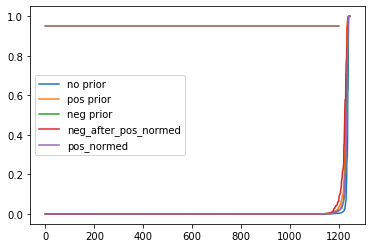

1


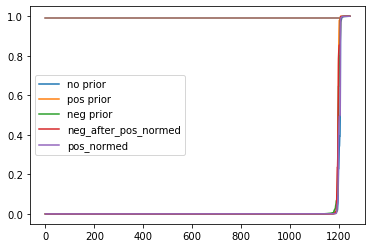

2


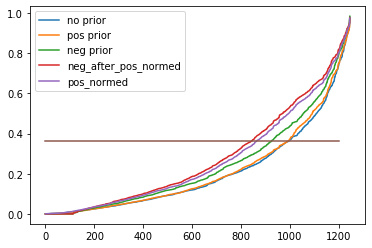

3


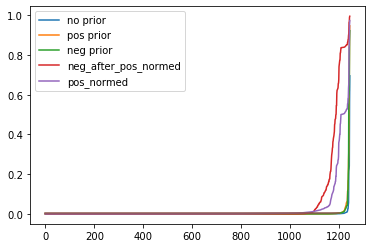

4


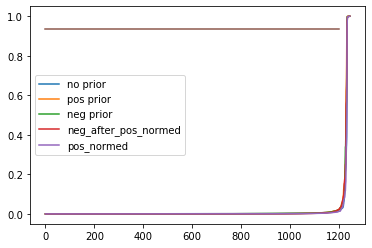

5


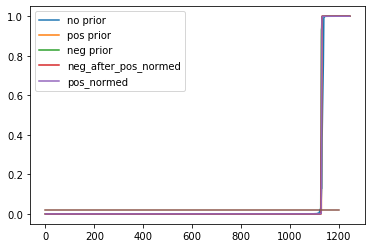

6


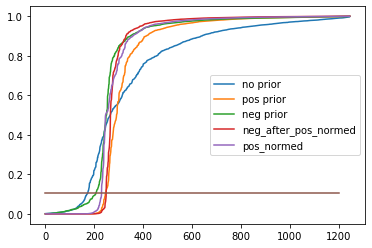

7


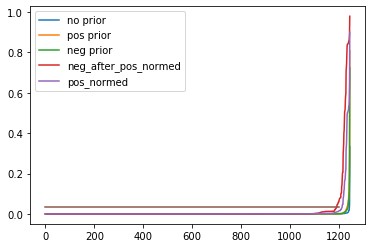

8


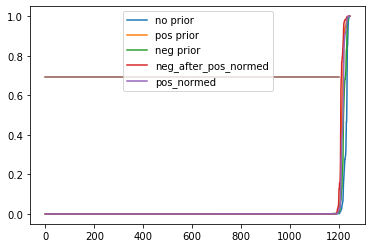

9


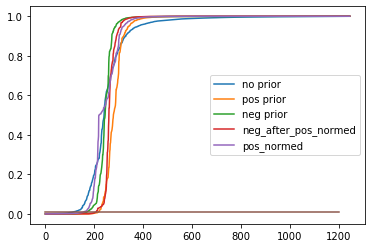

10


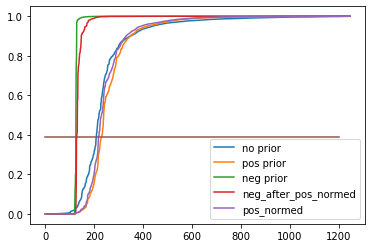

11


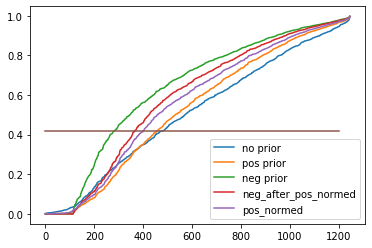

12


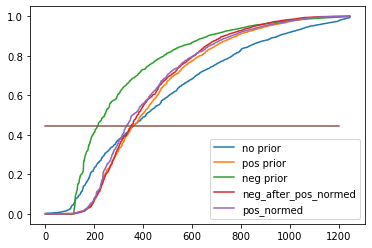

13


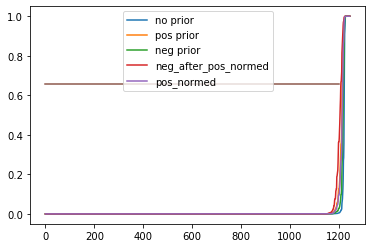

14


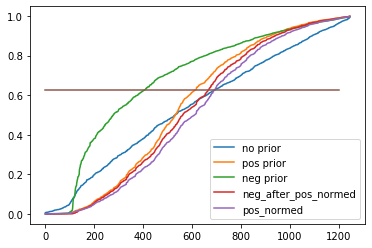

15


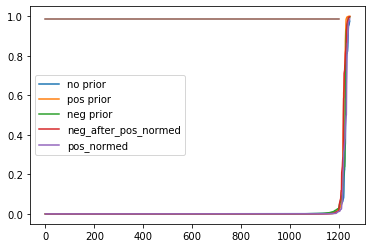

16


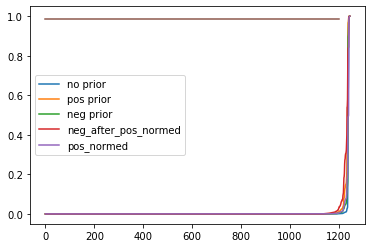

17


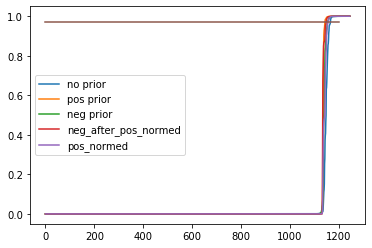

18


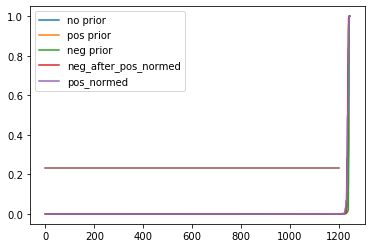

19


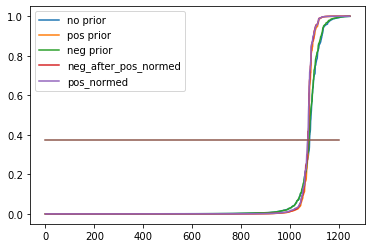

20


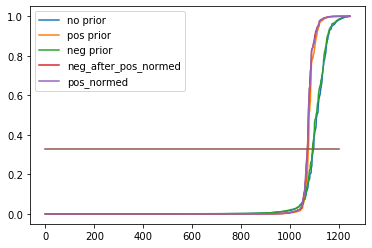

21


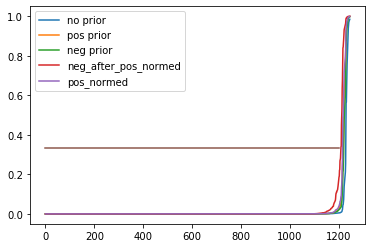

22


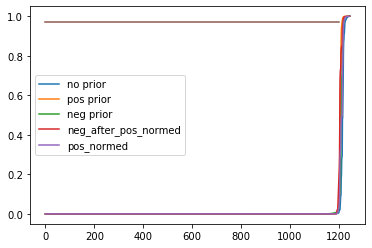

23


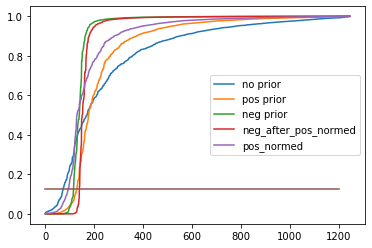

24


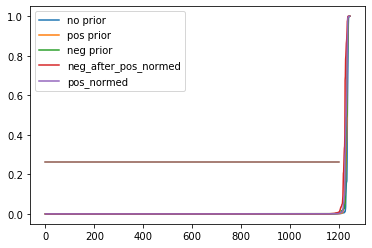

25


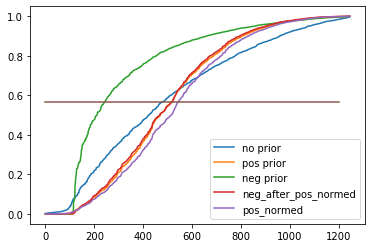

26


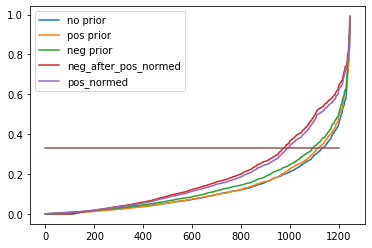

27


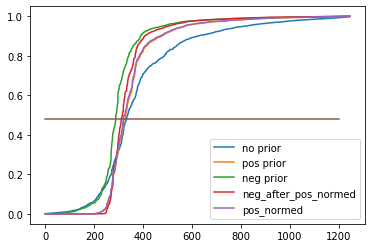

28


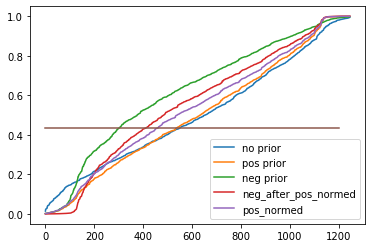

29


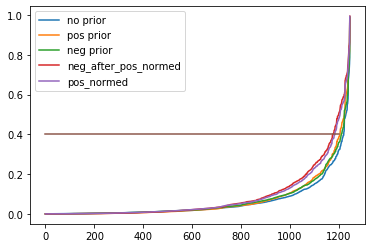

30


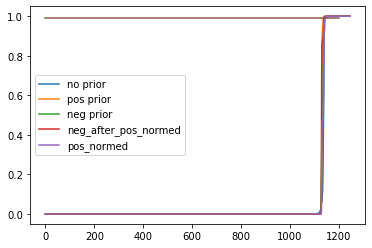

31


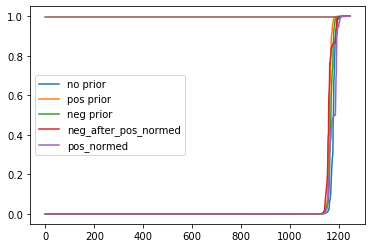

32


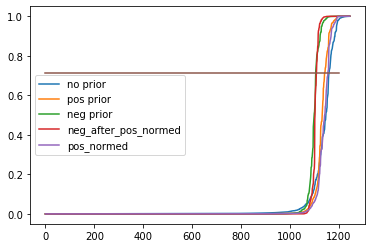

33


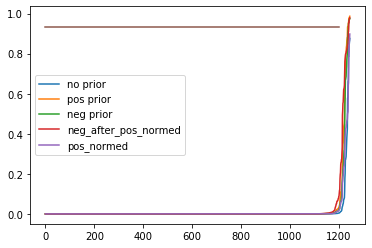

34


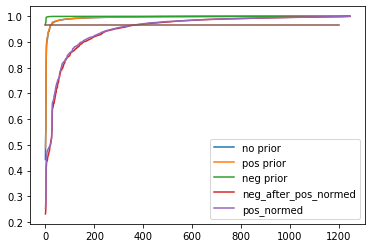

35


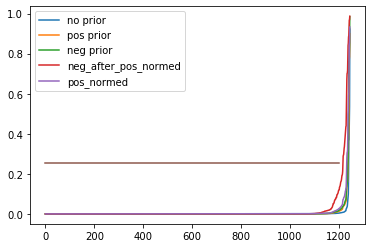

36


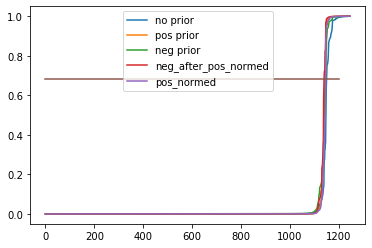

37


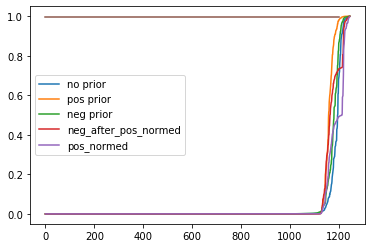

38


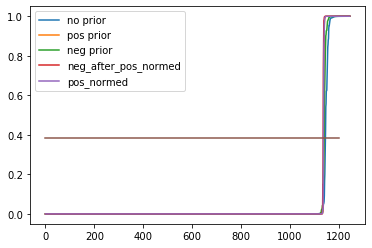

39


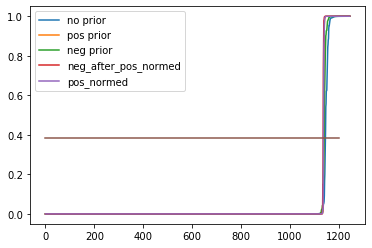

40


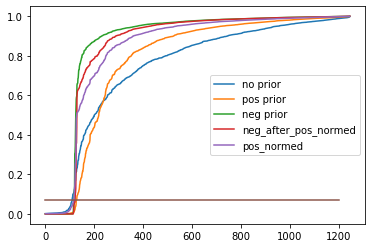

41


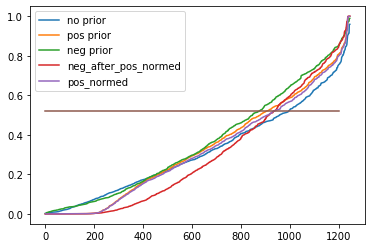

42


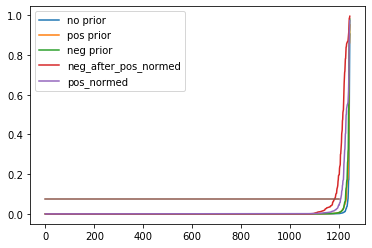

43


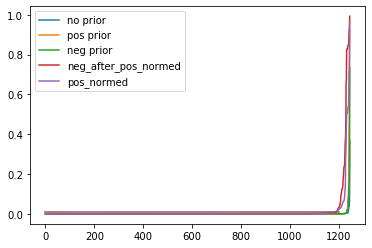

44


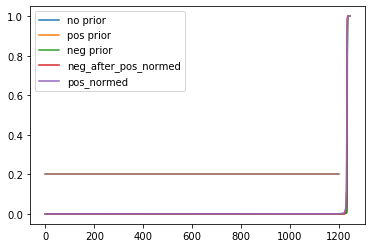

45


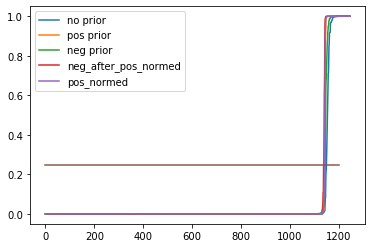

46


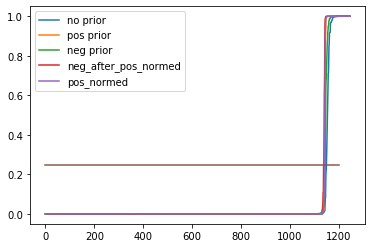

47


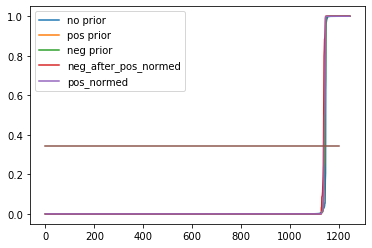

48


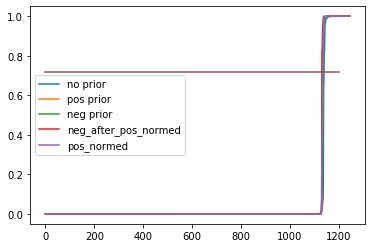

49


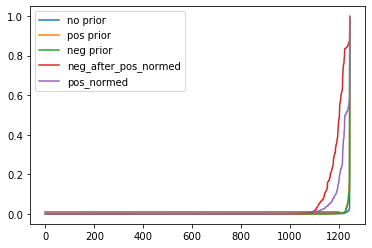

50


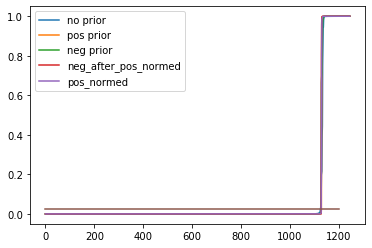

51


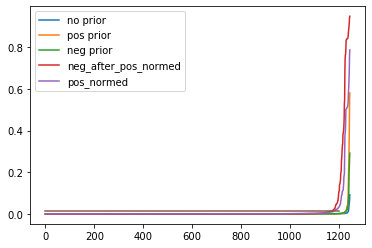

52


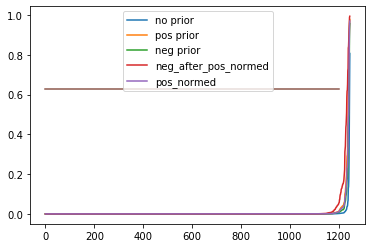

53


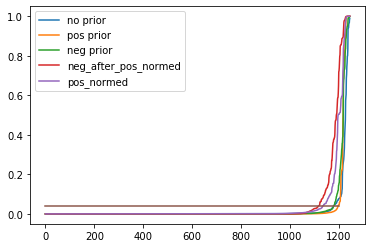

54


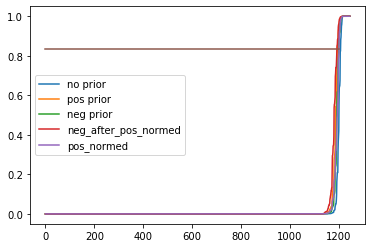

55


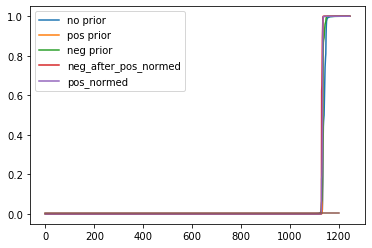

56


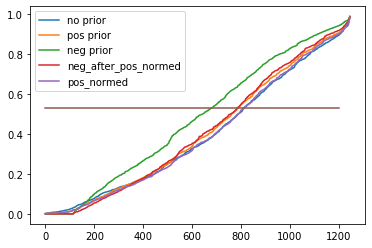

57


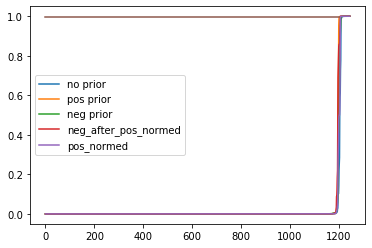

58


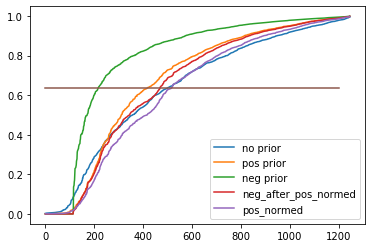

In [51]:
x = try_normalization(y_test, y_pred_after_prior_proba_pos, normalize_func)

(array([12.,  3.,  5.,  9.,  5.,  3.,  6.,  2.,  1., 13.]),
 array([0.004 , 0.1034, 0.2028, 0.3022, 0.4016, 0.501 , 0.6004, 0.6998,
        0.7992, 0.8986, 0.998 ]),
 <a list of 10 Patch objects>)

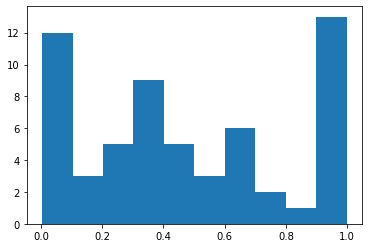

In [52]:
plt.hist(x[2])

## Other Visualizations and Statistics

In [53]:
#colors_dict

In [54]:
#len(pos_index), len(neg_index), len(set(pos_index).intersection(set(neg_index)))

In [55]:
#pos_index

In [56]:
#neg_index

In [57]:
def get_classification_df(y_test, y_pred):
    
    df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True, target_names=data._y_cols)).T.reset_index()
    return df

global colors_dict
colors_dict = {'red':0, 'green':0, 'blue':0}

global y_index
y_index = []

def highlight_greater(row):
    global colors_dict

    if row['f1-score'] > row['f1-score_prior']:
        color = 'red'
    elif row['f1-score'] < row['f1-score_prior']:
        color = 'green'
    else:
        color= 'blue'
        
    if not 'avg' in row['index']:
        colors_dict[color] += 1
        if color == 'red':
            y_index.append(row['index'])
        
    background = ['background-color: {}'.format(color) for _ in row]
    return background



df = get_classification_df(y_test, y_pred).join(get_classification_df(y_test, y_pred_after_prior), rsuffix = '_prior')
df.style.apply(highlight_greater, axis=1)

,index,precision,recall,f1-score,support,index_prior,precision_prior,recall_prior,f1-score_prior,support_prior
0,agent,0.785714,0.647059,0.709677,17,agent,0.909091,0.588235,0.714286,17
1,album,0.820513,0.914286,0.864865,35,album,0.820513,0.914286,0.864865,35
2,alia,0.380753,0.457286,0.415525,199,alia,0.378486,0.477387,0.422222,199
3,alma_mat,0.142857,0.266667,0.186047,15,alma_mat,0.162162,0.4,0.230769,15
4,alt,1,0.352941,0.521739,34,alt,1,0.352941,0.521739,34
5,artist,1,0.982456,0.99115,114,artist,0.982759,1,0.991304,114
6,associated_act,0.894351,0.9375,0.915418,912,associated_act,0.880881,0.964912,0.920984,912
7,award,0.2,0.333333,0.25,9,award,0.272727,0.333333,0.3,9
8,b-side,0.483871,0.882353,0.625,17,b-side,0.535714,0.882353,0.666667,17
9,background,0.954724,0.974874,0.964694,995,background,0.950292,0.979899,0.964869,995



17 red
11 blue
31 green

In [58]:
get_classification_df(y_pred_after_prior, y_pred_norm_neg_after_pos)

,index,precision,recall,f1-score,support
0,agent,1.000000,1.000000,1.000000,11.0
1,album,1.000000,1.000000,1.000000,39.0
2,alia,1.000000,0.828685,0.906318,251.0
3,alma_mat,1.000000,0.729730,0.843750,37.0
4,alt,1.000000,1.000000,1.000000,12.0
5,artist,1.000000,0.982759,0.991304,116.0
6,associated_act,0.991045,0.996997,0.994012,999.0
7,award,1.000000,1.000000,1.000000,11.0
8,b-side,1.000000,1.000000,1.000000,28.0
9,background,0.996105,0.997076,0.996590,1026.0


In [59]:
for c in range(y.shape[1]):
    plt.scatter(y_pred_proba[:, c], y_pred_after_prior_proba[:, c])
plt.show()

NameError: name 'y_pred_after_prior_proba' is not defined

In [ ]:
for c in range(y.shape[1]):
    plt.plot(y_pred_proba[:, c], '.')
    plt.plot(y_pred_after_prior_proba[:, c], '.')
    plt.show()

In [ ]:
label_count = len(y.columns)

In [ ]:
# T = minimum_spanning_tree(get_mutual_information(p_ij)).todense()
# G = nx.Graph(T, nodes=y.columns)
# G = nx.relabel_nodes(g, {i: c for i,c in zip(range(y.shape[1]), y.columns)})
# nx.draw_networkx(G, cmap=plt.get_cmap('jet'), with_labels=True,font_size=16, pos=nx.fruchterman_reingold_layout(G))
# fig = plt.gcf()
# fig.set_size_inches(18.5, 10.5)

In [ ]:
plt.imshow(p_ij)
plt.colorbar()

In [ ]:
plt.imshow(np.array((T != 0) * 1.) * p_ij)
plt.colorbar()

In [ ]:
E = get_mutual_information(p_ij)
plt.imshow(E)
plt.colorbar()

In [ ]:
plt.imshow(np.array((T != 0) * 1.) * E)
plt.colorbar()